In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torchvision.models as models
import torch.nn as nn
import torch
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from torch.amp import autocast, GradScaler
import random

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

In [2]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)
num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [3]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)   
])

test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [6]:
total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

train_dataset = TransformDataset(train_base, transform=train_transform)
val_dataset   = TransformDataset(val_base,   transform=val_transform)
test_dataset  = TransformDataset(test_base,  transform=test_transform)

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(loader)).item()


def validate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

# Fine tuning model

In [ ]:
if device == 'cuda':
    torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

pretrained_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in pretrained_model.parameters():
    param.requires_grad = False

num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_classes)
)
pretrained_model = pretrained_model.to(device)

train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = 100.0

# Warmup
num_epochs_warmup = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)
scaler = torch.amp.GradScaler('cuda')

for epoch in range(num_epochs_warmup):
    train_loss = train_one_epoch(pretrained_model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(pretrained_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(pretrained_model.state_dict(), "saved_models/pretrained_cnn.pth")
        print(f"Warmup epoch {epoch+1}/{num_epochs_warmup}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | New best saved.")
    else:
        print(f"Warmup epoch {epoch+1}/{num_epochs_warmup}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

elements_unfreezed = 0
for name, param in pretrained_model.named_parameters():
    if "layer4" in name or "fc" in name:
        elements_unfreezed += 1
        param.requires_grad = True
    else:
        param.requires_grad = False
print(f"Number of element unfreezed: {elements_unfreezed}")

# Fine tuning
num_epochs_finetuning = 20

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=1e-5, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_finetuning)


for epoch in range(num_epochs_finetuning):
    train_loss = train_one_epoch(pretrained_model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(pretrained_model, val_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(pretrained_model.state_dict(), "saved_models/pretrained_cnn.pth")
        print(f"Fine tuning epoch {epoch+1}/{num_epochs_finetuning}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | New best saved.")
    else:
        print(f"Fine tuning epoch {epoch+1}/{num_epochs_finetuning}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

if device == 'cuda':
    torch.cuda.empty_cache()

Warmup epoch 1/20: train_loss=0.7866, val_loss=0.5094, val_acc=0.8390 | New best saved.
Warmup epoch 2/20: train_loss=0.5159, val_loss=0.4289, val_acc=0.8491 | New best saved.
Warmup epoch 3/20: train_loss=0.4755, val_loss=0.4000, val_acc=0.8672 | New best saved.
Warmup epoch 4/20: train_loss=0.4705, val_loss=0.4709, val_acc=0.8290
Warmup epoch 5/20: train_loss=0.4277, val_loss=0.3675, val_acc=0.8672 | New best saved.
Warmup epoch 6/20: train_loss=0.4407, val_loss=0.3681, val_acc=0.8692
Warmup epoch 7/20: train_loss=0.4466, val_loss=0.3839, val_acc=0.8592
Warmup epoch 8/20: train_loss=0.4121, val_loss=0.3638, val_acc=0.8773 | New best saved.
Warmup epoch 9/20: train_loss=0.3855, val_loss=0.3516, val_acc=0.8692 | New best saved.
Warmup epoch 10/20: train_loss=0.4198, val_loss=0.3534, val_acc=0.8793
Warmup epoch 11/20: train_loss=0.4219, val_loss=0.3544, val_acc=0.8793
Warmup epoch 12/20: train_loss=0.4316, val_loss=0.3416, val_acc=0.8732 | New best saved.
Warmup epoch 13/20: train_loss=

### Learning curves

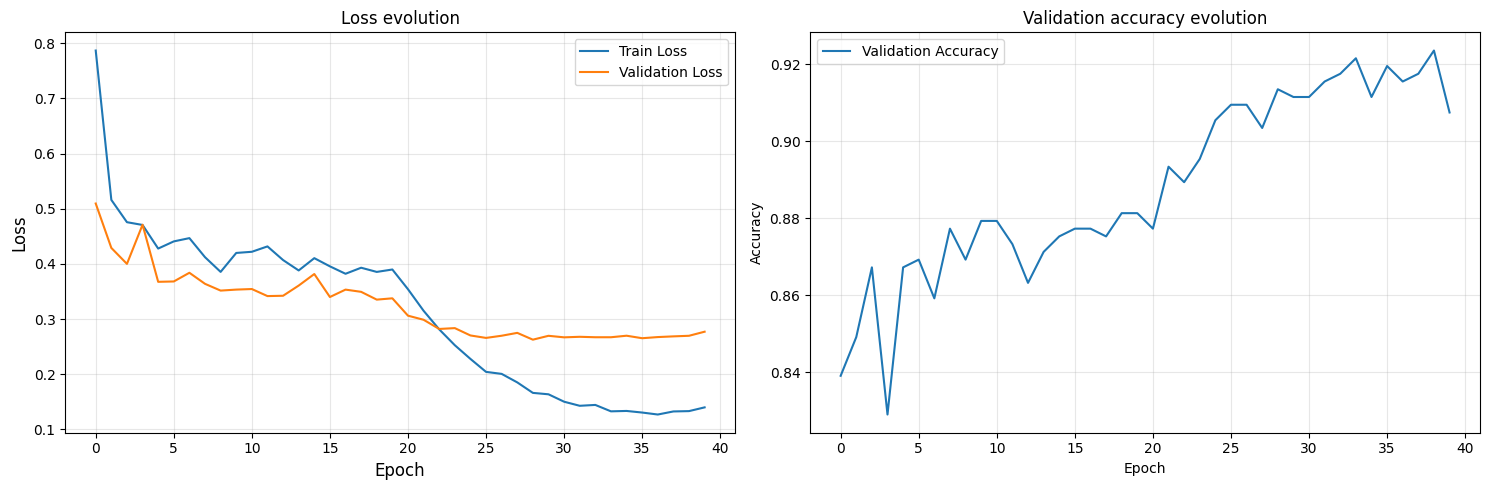

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation accuracy evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

In [48]:
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_classes)
)

pretrained_model = model.to(device)
pretrained_model.load_state_dict(torch.load("saved_models/pretrained_cnn.pth"))
pretrained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Test accuracy: 0.9215

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity     0.8916    0.9193    0.9052       161
         Normal     0.9056    0.8907    0.8981       183
Viral Pneumonia     0.9735    0.9608    0.9671       153

       accuracy                         0.9215       497
      macro avg     0.9235    0.9236    0.9235       497
   weighted avg     0.9219    0.9215    0.9216       497



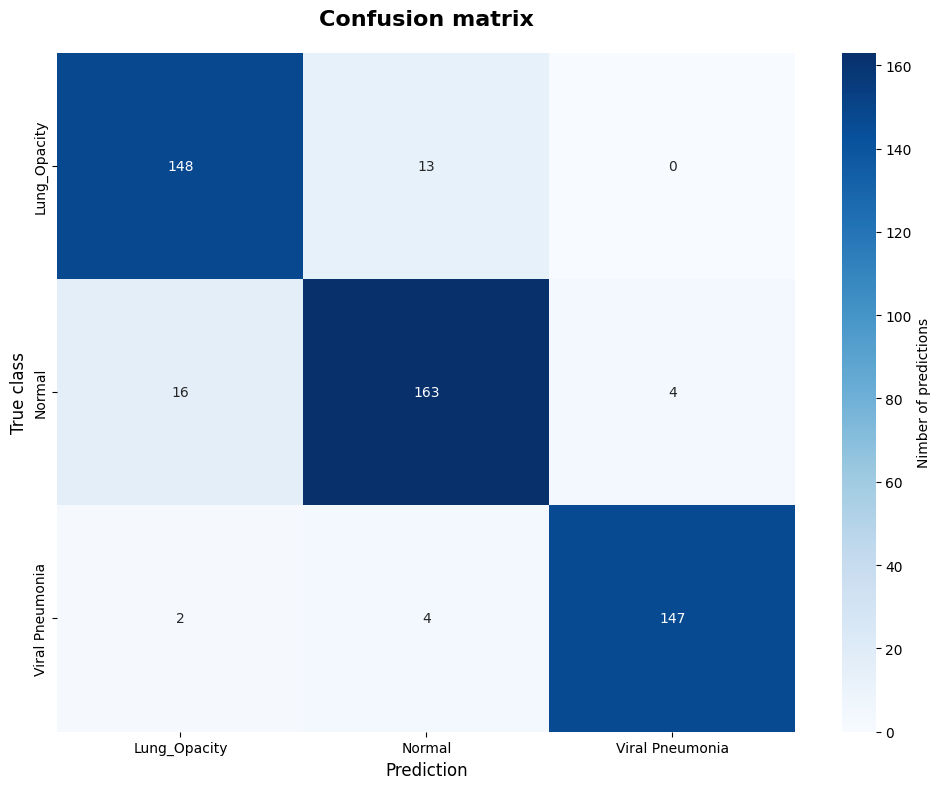

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast(device):
            outputs = pretrained_model(images)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names,
            cbar_kws={'label': 'Nimber of predictions'})
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.tight_layout()
plt.show()

### Visualizing convolution kernel

In [50]:
import torch

first_conv_layer = pretrained_model.conv1 
kernels = first_conv_layer.weight.data.cpu()

print(f"Shape: {kernels.shape}")
print(f"Filters amount: {kernels.shape[0]}")
print(f"Size: {kernels.shape[2]}x{kernels.shape[3]}")

Shape: torch.Size([64, 3, 7, 7])
Filters amount: 64
Size: 7x7


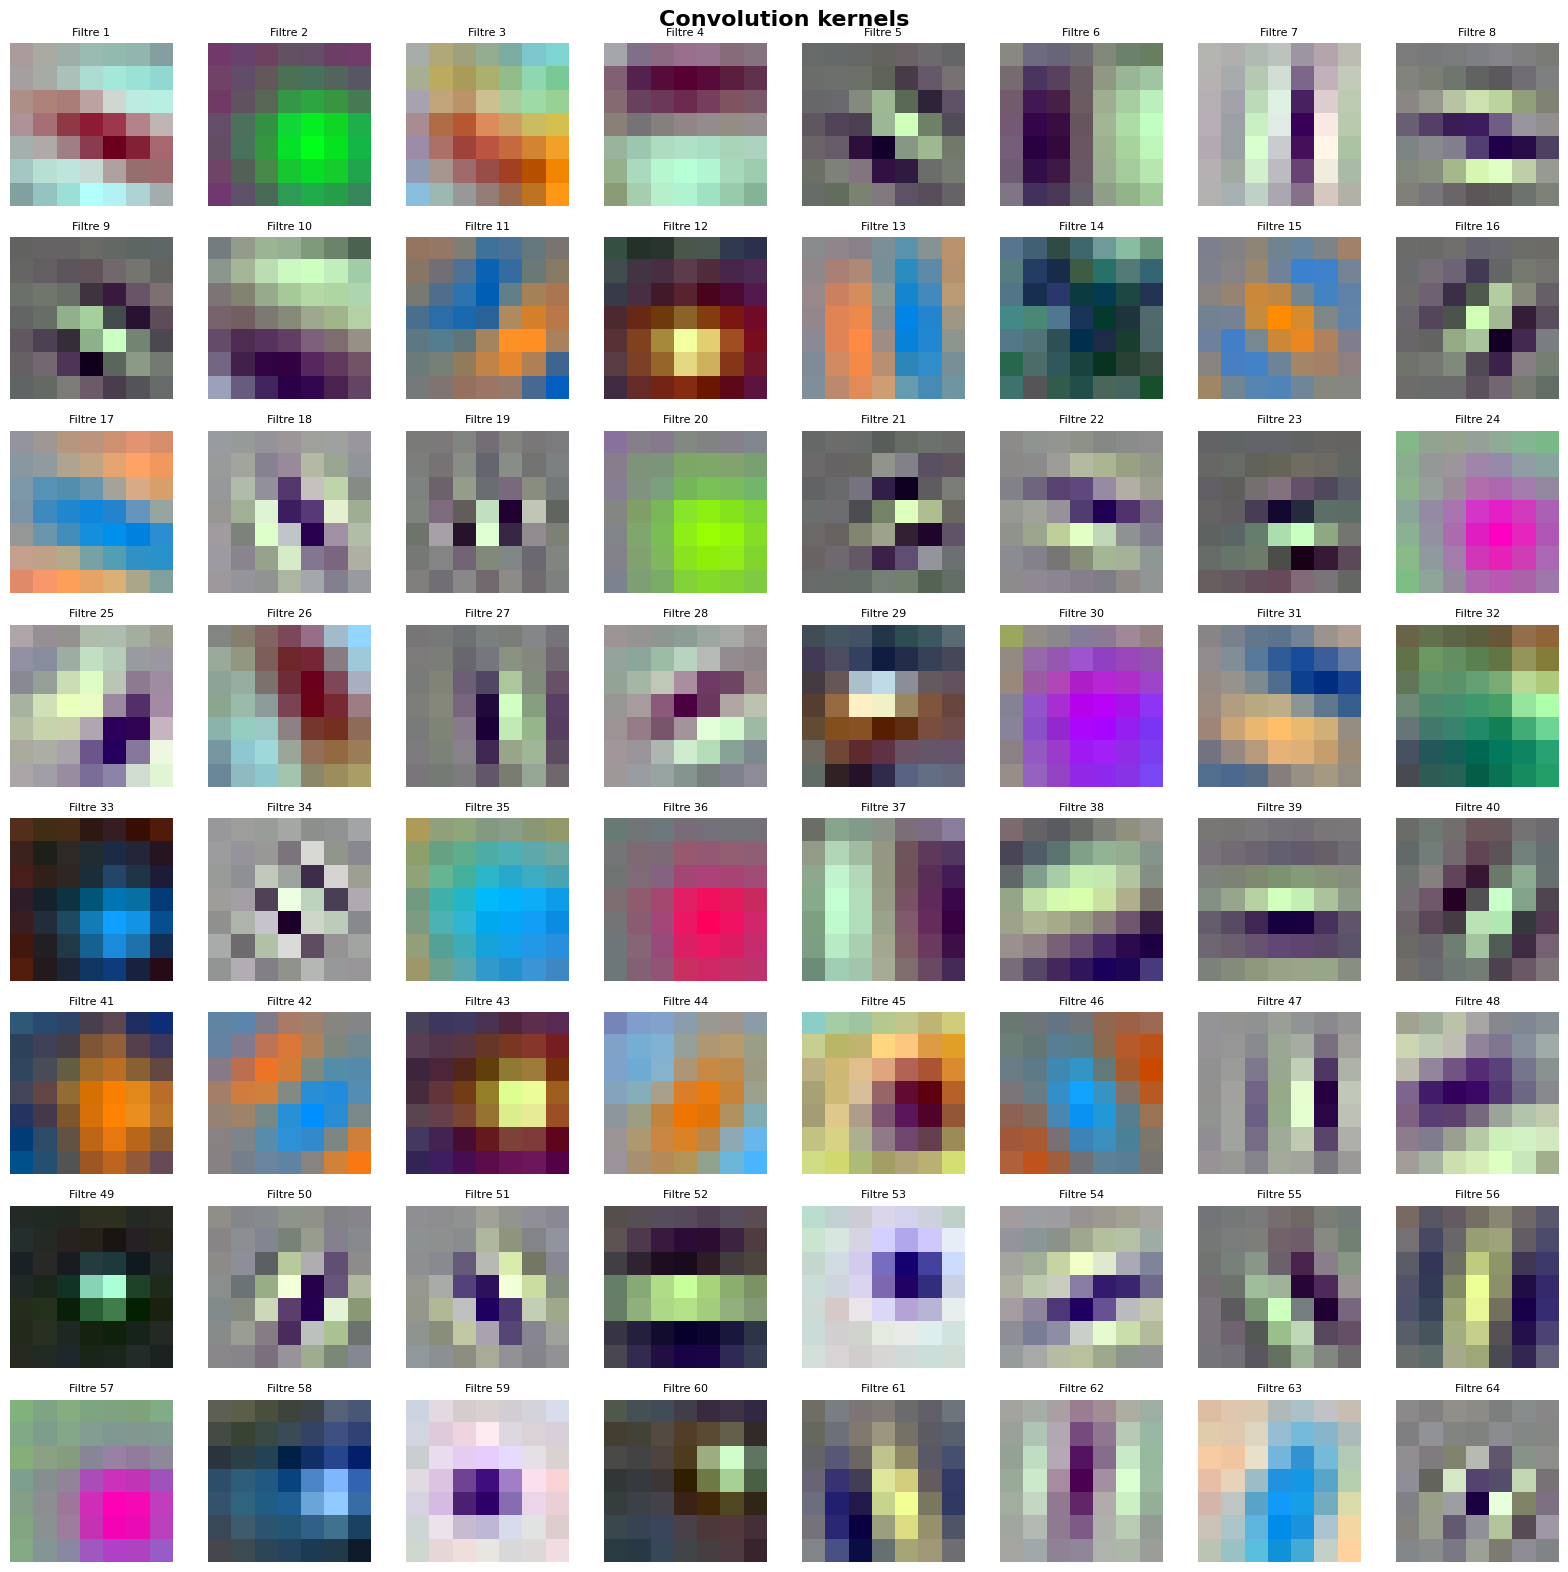

In [51]:
n_filters = kernels.shape[0]
n_cols = 8
n_rows = (n_filters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*2))
axes = axes.flatten()

for i in range(n_filters):
    kernel = kernels[i].numpy()

    kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min() + 1e-8)

    kernel_display = np.transpose(kernel_norm, (1, 2, 0))
    
    axes[i].imshow(kernel_display)
    axes[i].set_title(f'Filtre {i+1}', fontsize=8)
    axes[i].axis('off')


for i in range(n_filters, len(axes)):
    axes[i].axis('off')

plt.suptitle('Convolution kernels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

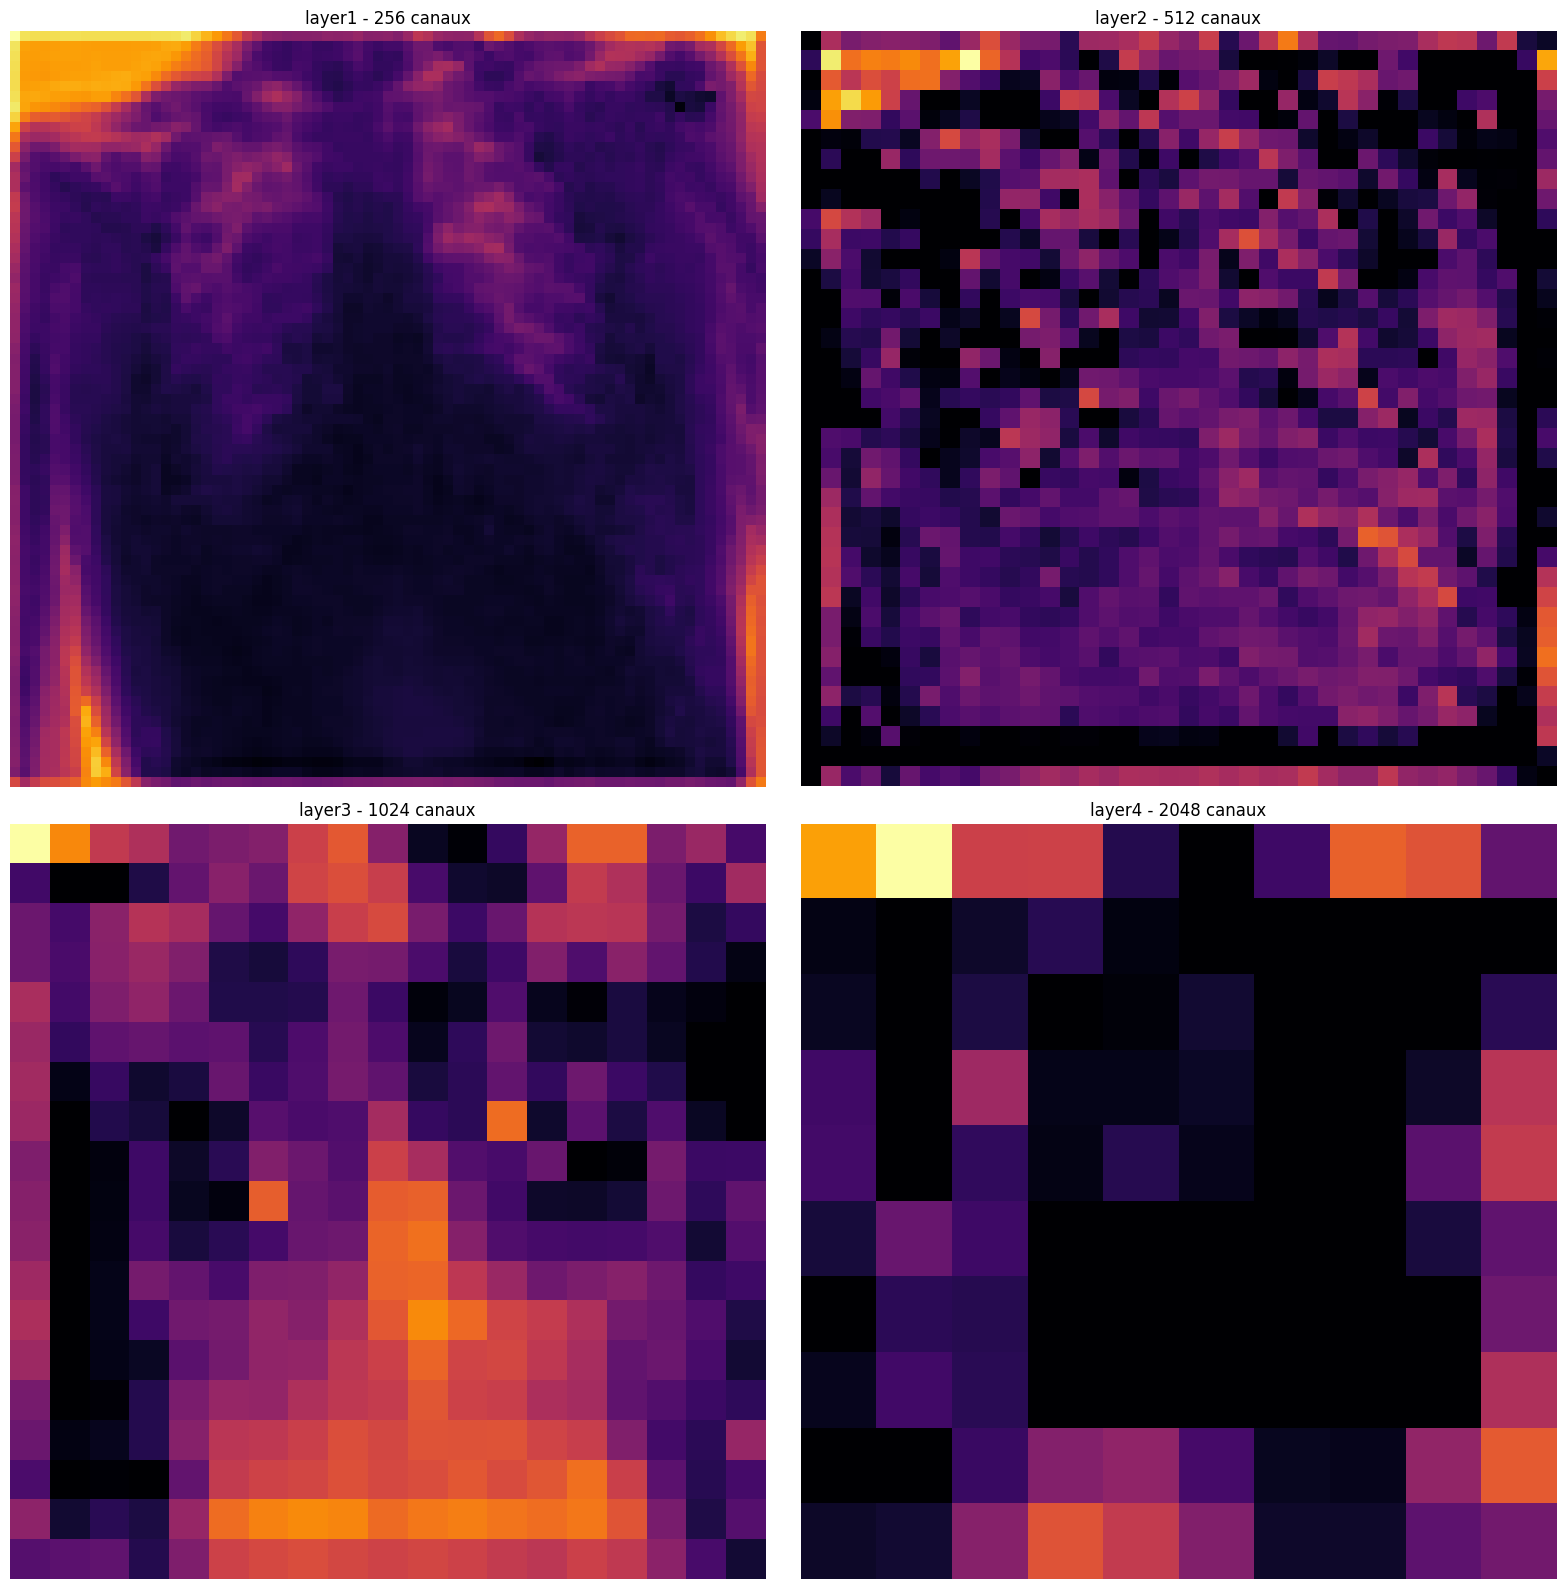

In [52]:
import math

first_image, first_label = dataset[0] 
first_image_tensor = torch.from_numpy(first_image).permute(2, 0, 1).float() / 255.0 
first_image_tensor = first_image_tensor.unsqueeze(0).to(device)

layers_outputs = {}

def get_activation(name):
    def hook(model, input, output):
        layers_outputs[name] = output.detach()
    return hook

pretrained_model.layer1.register_forward_hook(get_activation('layer1'))
pretrained_model.layer2.register_forward_hook(get_activation('layer2'))
pretrained_model.layer3.register_forward_hook(get_activation('layer3'))
pretrained_model.layer4.register_forward_hook(get_activation('layer4'))

pretrained_model.eval()
with torch.no_grad():
    _ = pretrained_model(first_image_tensor)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']

for idx, layer_name in enumerate(layer_names):
    ax = axes[idx // 2, idx % 2]
    
    feature_tensor = layers_outputs[layer_name].squeeze(0).cpu()
    n_maps = min(64, feature_tensor.shape[0])
    
    cols = 8
    rows = math.ceil(n_maps / cols)

    grid_img = []
    for i in range(n_maps):
        grid_img.append(feature_tensor[i].numpy())
    
    ax.imshow(feature_tensor[0].numpy(), cmap='inferno')
    ax.set_title(f'{layer_name} - {feature_tensor.shape[0]} canaux')
    ax.axis('off')

plt.tight_layout()
plt.show()